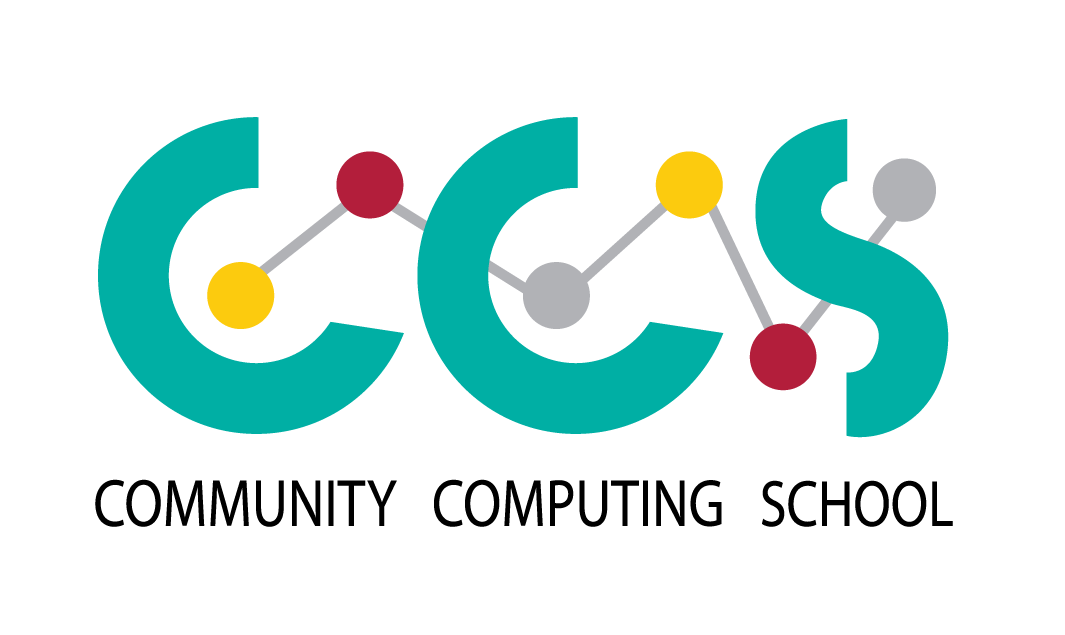

# Final Model Selection And Parameter Optimization

## Import Libraries

In [148]:
from datetime import datetime
import numpy as np
import pandas  as pd
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import LocalOutlierFactor
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, recall_score

## Load Dataset

In [2]:
df = pd.read_csv('../DataSet/heart_disease_clean.csv')

In [3]:
df.shape

(303, 14)

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,male,typical angina,145.0,233.0,True,2.0,150.0,no,2.3,downsloping,0.0,6.0,0
1,67.0,male,asymptomatic,160.0,286.0,False,2.0,108.0,yes,1.5,flat,3.0,3.0,1
2,67.0,male,asymptomatic,120.0,229.0,False,2.0,129.0,yes,2.6,flat,2.0,7.0,1
3,37.0,male,non-anginal pain,130.0,250.0,False,0.0,187.0,no,3.5,downsloping,0.0,3.0,0
4,41.0,female,atypical angina,130.0,204.0,False,2.0,172.0,no,1.4,upsloping,0.0,3.0,0


## Split Data Set

In [5]:
nominal_features = ['sex', 'cp', 'exang', 'slope', 'thal', 'fbs', 'restecg', 'ca']

In [6]:
dummies = pd.get_dummies(df[nominal_features], drop_first=True)
df = df.drop(nominal_features, axis=1)
df = pd.concat([df, dummies], axis=1)

In [7]:
X = df.drop("num", axis=1)
y = df["num"]

In [8]:
y = LabelEncoder().fit_transform(y)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

## Final Selected Model (Base Model)

In [12]:
pca_n_components = 12

In [13]:
init_time = datetime.now()
model = SVC(gamma='auto')
pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
pipeline.fit(X_train, y_train)
results = pipeline.predict(X_test)
print(classification_report(y_test, results))
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.83      0.89      0.86        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

Execution time :  0:00:00.068178


simply attemp to distinguish presence (values 1) from absence (value 0)

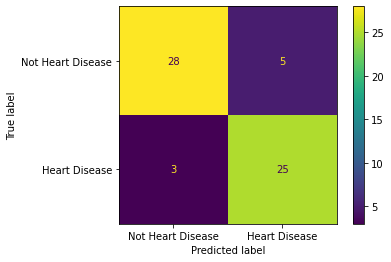

In [14]:
plot_confusion_matrix(pipeline, X_test, y_test, values_format='d', display_labels=["Not Heart Disease","Heart Disease"]);

## Parameter Optimization

In [47]:
# defining parameter range 
#'svc__gama':['scale', 'auto'], 'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],  
              'svc__gamma': ['scale', 'auto'], 
              'svc__kernel': ['rbf', 'linear', 'sigmoid', 'precomputed', 'poly']}  

In [48]:
from scipy.stats import reciprocal, uniform

In [49]:
param_distributions = {"svc__gamma": [1, 0.1, 0.01, 0.001, 0.0001], 
                       "svc__C": [0.1, 1, 10, 100, 1000],
                       'svc__kernel': ['rbf', 'linear', 'sigmoid', 'precomputed', 'poly']}

### Grid Search

In [96]:
pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('svc', SVC())])

In [98]:
init_time = datetime.now()
grid_search = GridSearchCV(pipeline,
                        param_grid,
                        scoring='accuracy',
                        cv = 10,
                        n_jobs = 10,
                        verbose=False)
grid_search.fit(X_train, y_train)
grid_predictions = grid_search.predict(X_test)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Execution time :  0:00:12.146514


In [99]:
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.83      0.89      0.86        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [53]:
grid_search.best_params_

{'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

In [54]:
init_time = datetime.now()
grid_search = GridSearchCV(pipeline,
                        param_distributions,
                        scoring='accuracy',
                        cv = 10,
                        n_jobs = 10,
                        verbose=False)
grid_search.fit(X_train, y_train)
grid_predictions = grid_search.predict(X_test)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Execution time :  0:00:35.111237


In [55]:
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88        33
           1       0.83      0.89      0.86        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [46]:
grid_search.best_params_

{'svc__C': 0.1, 'svc__gamma': 1, 'svc__kernel': 'linear'}

### Hyperopt Optimization

In [56]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [63]:
space4svm = {
    'C': hp.uniform('C', 0, 20),
    'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'gamma': hp.uniform('gamma', 0, 20)
}

In [64]:
best_score=0

In [69]:
def hyperparameter_tuning(space):
    global best_score
    #print(space)
    model = SVC(C=space["C"],
               kernel=space["kernel"],
               gamma=space["gamma"]
               )
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('svc', model)])
    
    pipeline.fit(X_train, y_train)

    pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    if best_score==0:
        best_score = accuracy
    if accuracy > best_score:
        best_score = accuracy
        print (f"SCORE: {best_score:.4f}")
        print ("PARAMS:", space)
    #change the metric if you like
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}

In [70]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space4svm,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print (best)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-11 12:02:51.777525
100%|██████████| 100/100 [00:08<00:00, 11.48trial/s, best loss: -0.8852459016393442]
{'C': 0.011064399497800127, 'gamma': 6.488497621983595, 'kernel': 1, 'normalize': 1, 'scale': 1}
Execution time :  0:00:08.720465


In [71]:
model = trials.best_trial['result']['model']
print (model)

SVC(C=0.011064399497800127, gamma=6.488497621983595, kernel='sigmoid')


In [72]:
init_time = datetime.now()
model = SVC(C=0.011064399497800127, gamma=6.488497621983595, kernel='sigmoid')
pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
pipeline.fit(X_train, y_train)
results = pipeline.predict(X_test)
print(classification_report(y_test, results))
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89        33
           1       0.86      0.89      0.88        28

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61

Execution time :  0:00:00.051169


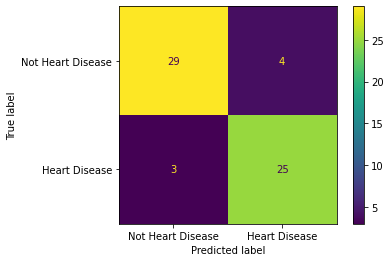

In [73]:
plot_confusion_matrix(pipeline, X_test, y_test, values_format='d', display_labels=["Not Heart Disease","Heart Disease"]);

### skopt Optimization

In [81]:
from skopt import BayesSearchCV

In [88]:
space4svm = {
    'svc__C': hp.uniform('svc__C', 0, 20),
    'svc__kernel': hp.choice('svc__kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
    'svc__gamma': hp.uniform('svc__gamma', 0, 20)
}

In [89]:
pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('svc', SVC())])

In [90]:
skopt_search = BayesSearchCV(estimator=pipeline, search_spaces=param_grid,
                           cv=5, n_iter=50,
                           verbose=0, n_jobs=-1,
                           )

In [91]:
# callback handler
def on_step(optim_result):
    score = skopt_search.best_score_
    print (f"{datetime.now()}: Best Score- {score:.4f}")
    if score >= 0.98:
        print('Interrupting!')
        return True

In [92]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
# perform the search
skopt_search.fit(X_train, y_train, callback=on_step)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-11 12:19:49.735054
2021-01-11 12:19:49.851195: Best Score- 0.8347
2021-01-11 12:19:49.943147: Best Score- 0.8347
2021-01-11 12:19:50.043865: Best Score- 0.8347
2021-01-11 12:19:50.123136: Best Score- 0.8347
2021-01-11 12:19:50.200789: Best Score- 0.8347
2021-01-11 12:19:50.280331: Best Score- 0.8347
2021-01-11 12:19:50.361034: Best Score- 0.8347
2021-01-11 12:19:50.441393: Best Score- 0.8347
2021-01-11 12:19:50.528072: Best Score- 0.8347
2021-01-11 12:19:51.206937: Best Score- 0.8347
2021-01-11 12:19:52.250037: Best Score- 0.8347
2021-01-11 12:19:53.314883: Best Score- 0.8347
2021-01-11 12:19:54.604629: Best Score- 0.8347
2021-01-11 12:19:55.873085: Best Score- 0.8347
2021-01-11 12:19:57.227828: Best Score- 0.8347
2021-01-11 12:19:58.752590: Best Score- 0.8430
2021-01-11 12:20:00.107717: Best Score- 0.8430
2021-01-11 12:20:01.619006: Best Score- 0.8430
2021-01-11 12:20:03.067653: Best Score- 0.8430
2021-01-11 12:20:04.632063: Best Score- 0.8430
2021-01-11 12:20:

/home/mhossain/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2021-01-11 12:20:26.463689: Best Score- 0.8430
2021-01-11 12:20:28.446355: Best Score- 0.8430


/home/mhossain/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2021-01-11 12:20:30.434117: Best Score- 0.8430
2021-01-11 12:20:32.606835: Best Score- 0.8430
2021-01-11 12:20:34.942470: Best Score- 0.8430


/home/mhossain/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2021-01-11 12:20:37.359543: Best Score- 0.8430


/home/mhossain/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2021-01-11 12:20:40.189839: Best Score- 0.8430
2021-01-11 12:20:42.796878: Best Score- 0.8430
2021-01-11 12:20:45.691325: Best Score- 0.8430
2021-01-11 12:20:48.466306: Best Score- 0.8430


/home/mhossain/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2021-01-11 12:20:53.911835: Best Score- 0.8430
2021-01-11 12:20:56.896175: Best Score- 0.8430
2021-01-11 12:21:00.050086: Best Score- 0.8430


/home/mhossain/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2021-01-11 12:21:03.590504: Best Score- 0.8430


/home/mhossain/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2021-01-11 12:21:06.889749: Best Score- 0.8430


/home/mhossain/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2021-01-11 12:21:12.753090: Best Score- 0.8430


/home/mhossain/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2021-01-11 12:21:15.956947: Best Score- 0.8430
2021-01-11 12:21:19.250876: Best Score- 0.8430


/home/mhossain/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2021-01-11 12:21:22.701263: Best Score- 0.8430
2021-01-11 12:21:25.917027: Best Score- 0.8430


/home/mhossain/anaconda3/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


2021-01-11 12:21:31.596118: Best Score- 0.8430
2021-01-11 12:21:34.993042: Best Score- 0.8430
Execution time :  0:01:45.384668


In [93]:
# report the best result
print(skopt_search.best_score_)
print(skopt_search.best_params_)

0.8429752066115702
OrderedDict([('svc__C', 100.0), ('svc__gamma', 'scale'), ('svc__kernel', 'linear')])


In [94]:
skopt_best_estimator = skopt_search.best_estimator_
print (skopt_best_estimator)

Pipeline(steps=[('power', PowerTransformer()), ('scaler', RobustScaler()),
                ('pca', PCA(n_components=12)),
                ('svc', SVC(C=100.0, kernel='linear'))])


In [100]:
init_time = datetime.now()
model = SVC(C=0.011064399497800127, gamma=6.488497621983595, kernel='sigmoid')
pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', SVC(C=100.0, kernel='linear'))])
pipeline.fit(X_train, y_train)
results = pipeline.predict(X_test)
print(classification_report(y_test, results))
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85        33
           1       0.79      0.93      0.85        28

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61

Execution time :  0:00:00.116545


### Bayesian Optimization

In [129]:
from bayes_opt import BayesianOptimization

In [167]:
#'kernel': ['rbf', 'linear', 'sigmoid', 'precomputed', 'poly']
svm_pbounds = {
    'C': (1.0, 20),
    'gamma': (1.0, 20)
} 

In [171]:
def svm_hyper_param(C, gamma):

    model = SVC(C=C, kernel='linear', gamma=gamma)
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
    
    #cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=101)
    cv_result = np.mean(cross_val_score(estimator=pipeline, X=X_train, y=y_train, 
                                        cv=5, scoring='accuracy', verbose = 0))
    return cv_result

svm_optimizer = BayesianOptimization(
    f=svm_hyper_param,
    pbounds=svm_pbounds,
    #verbose=2,
    random_state=1,
)

In [172]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
init_points = 10 
n_iter = 490 #The more steps the more likely to find a good maximum you are.
svm_optimizer.maximize(n_iter=n_iter, init_points=init_points)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

Job Started at: 2021-01-11 13:35:02.352624
|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  1        |  0.8429   |  8.923    |  14.69    |
|  2        |  0.8386   |  1.002    |  6.744    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  3        |  0.8428   |  3.788    |  2.754    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  4        |  0.8387   |  4.539    |  7.566    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  5        |  0.8429   |  8.539    |  11.24    |
|  6        |  0.8429   |  8.965    |  14.02    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  7        |  0.8387   |  4.885    |  17.68    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  8        |  0.8386   |  1.52     |  13.74    |
|  9        |  0.8429   |  8.929    |  11.62    |
|  10       |  0.8428   |  3.667    |  4.764    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  11       |  0.8429   |  12.99    |  15.58    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  12       |  0.8429   |  14.28    |  10.66    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  13       |  0.8429   |  11.79    |  6.747    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  14       |  0.8429   |  17.03    |  6.176    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  15       |  0.8429   |  13.99    |  1.876    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  16       |  0.8429   |  8.99     |  2.117    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  17       |  0.8429   |  19.7     |  11.74    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  18       |  0.8429   |  18.79    |  17.12    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  19       |  0.8429   |  19.69    |  1.141    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  20       |  0.8429   |  14.7     |  19.99    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  21       |  0.8429   |  20.0     |  20.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  22       |  0.8429   |  19.91    |  7.178    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  23       |  0.8429   |  10.85    |  20.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  24       |  0.8429   |  16.58    |  13.84    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  25       |  0.8429   |  20.0     |  4.079    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  26       |  0.8429   |  6.876    |  4.089    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  27       |  0.8429   |  16.79    |  1.074    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  28       |  0.8429   |  17.28    |  9.644    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  29       |  0.8429   |  20.0     |  14.73    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  30       |  0.8386   |  1.004    |  1.123    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  31       |  0.8429   |  6.514    |  1.0      |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  32       |  0.8429   |  14.12    |  4.811    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  33       |  0.8429   |  10.76    |  9.469    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  34       |  0.8429   |  11.17    |  17.43    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  35       |  0.8429   |  11.42    |  1.0      |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  36       |  0.8429   |  15.64    |  17.22    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  37       |  0.8429   |  17.2     |  19.98    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  38       |  0.8429   |  14.38    |  7.868    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  39       |  0.8429   |  11.26    |  3.836    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  40       |  0.8429   |  5.226    |  3.38     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  41       |  0.8429   |  12.1     |  12.93    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  42       |  0.8429   |  9.203    |  6.177    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  43       |  0.8429   |  17.23    |  3.424    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  44       |  0.8429   |  20.0     |  9.488    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  45       |  0.8429   |  10.71    |  14.92    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  46       |  0.8429   |  12.88    |  18.77    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  47       |  0.8429   |  14.44    |  13.31    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  48       |  0.8429   |  17.02    |  11.79    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  49       |  0.8429   |  9.083    |  4.258    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  50       |  0.8429   |  19.95    |  17.91    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  51       |  0.8429   |  9.186    |  8.757    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  52       |  0.8429   |  8.095    |  1.008    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  53       |  0.8429   |  18.55    |  13.52    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  54       |  0.8429   |  18.76    |  5.398    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  55       |  0.8429   |  18.25    |  7.896    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  56       |  0.8429   |  12.5     |  20.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  57       |  0.8429   |  18.67    |  2.3      |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  58       |  0.8429   |  17.35    |  15.64    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  59       |  0.8429   |  15.01    |  15.38    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  60       |  0.8429   |  7.249    |  2.402    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  61       |  0.8429   |  15.28    |  3.135    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  62       |  0.8429   |  12.83    |  9.087    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  63       |  0.8429   |  14.96    |  1.0      |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  64       |  0.8428   |  3.862    |  3.821    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  65       |  0.8387   |  4.776    |  1.0      |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  66       |  0.8386   |  1.018    |  19.88    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  67       |  0.8429   |  8.401    |  20.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  68       |  0.8429   |  9.147    |  17.84    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  69       |  0.8429   |  6.706    |  12.92    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  70       |  0.8429   |  12.06    |  11.06    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  71       |  0.8429   |  17.18    |  18.25    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  72       |  0.8429   |  16.15    |  8.164    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  73       |  0.8429   |  15.21    |  6.119    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  74       |  0.8429   |  10.39    |  7.631    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  75       |  0.8429   |  12.29    |  2.607    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  76       |  0.8429   |  13.81    |  17.19    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  77       |  0.8429   |  18.71    |  19.17    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  78       |  0.8429   |  7.182    |  14.54    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  79       |  0.8429   |  10.68    |  5.459    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  80       |  0.8429   |  18.59    |  10.64    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  81       |  0.8429   |  10.43    |  2.473    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  82       |  0.8429   |  12.99    |  1.0      |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  83       |  0.8429   |  12.67    |  5.241    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  84       |  0.8429   |  20.0     |  16.22    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  85       |  0.8429   |  15.59    |  9.851    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  86       |  0.8429   |  9.696    |  19.15    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  87       |  0.8429   |  9.895    |  16.3     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  88       |  0.8429   |  20.0     |  2.501    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  89       |  0.8429   |  10.59    |  12.36    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  90       |  0.8429   |  15.42    |  11.92    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  91       |  0.8429   |  16.16    |  4.713    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  92       |  0.8429   |  15.41    |  18.72    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  93       |  0.8429   |  7.858    |  12.91    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  94       |  0.8429   |  9.833    |  10.57    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  95       |  0.8429   |  13.33    |  6.708    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  96       |  0.8429   |  19.99    |  13.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  97       |  0.8429   |  7.572    |  5.781    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  98       |  0.8429   |  13.44    |  11.96    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  99       |  0.8429   |  19.89    |  5.746    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  100      |  0.8429   |  5.513    |  4.86     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  101      |  0.8429   |  18.36    |  1.018    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  102      |  0.8429   |  18.66    |  15.28    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  103      |  0.8429   |  8.159    |  16.29    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  104      |  0.8429   |  12.99    |  14.16    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  105      |  0.8429   |  13.41    |  3.548    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  106      |  0.8429   |  7.197    |  1.222    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  107      |  0.8429   |  9.604    |  1.067    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  108      |  0.8429   |  6.677    |  11.26    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  109      |  0.8429   |  8.173    |  7.515    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  110      |  0.8429   |  7.721    |  9.627    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  111      |  0.8429   |  11.7     |  16.18    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  112      |  0.8429   |  18.55    |  3.942    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  113      |  0.8429   |  11.88    |  8.101    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  114      |  0.8386   |  2.595    |  3.533    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  115      |  0.8387   |  4.513    |  4.483    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  116      |  0.8429   |  15.99    |  10.71    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  117      |  0.8386   |  2.134    |  17.55    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  118      |  0.8429   |  8.658    |  11.4     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  119      |  0.8429   |  16.2     |  17.79    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  120      |  0.8429   |  6.332    |  5.345    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  121      |  0.8429   |  13.45    |  16.39    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  122      |  0.8429   |  17.48    |  4.924    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  123      |  0.8429   |  19.95    |  2.522    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  124      |  0.8429   |  18.34    |  12.09    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  125      |  0.8429   |  11.41    |  18.71    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  126      |  0.8429   |  18.67    |  9.185    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  127      |  0.8429   |  16.29    |  2.242    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  128      |  0.8429   |  7.887    |  18.57    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  129      |  0.8429   |  12.54    |  17.4     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  130      |  0.8429   |  5.165    |  11.94    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  131      |  0.8429   |  5.31     |  13.76    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  132      |  0.8429   |  14.19    |  9.346    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  133      |  0.8429   |  6.922    |  20.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  134      |  0.8429   |  10.38    |  13.67    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  135      |  0.8428   |  3.832    |  11.04    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  136      |  0.8429   |  5.422    |  10.44    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  137      |  0.8386   |  3.039    |  5.487    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  138      |  0.8429   |  17.48    |  2.174    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  139      |  0.8429   |  6.232    |  3.1      |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  140      |  0.8429   |  13.14    |  7.818    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  141      |  0.8429   |  11.64    |  14.09    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  142      |  0.8429   |  18.72    |  6.625    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  143      |  0.8429   |  17.71    |  14.44    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  144      |  0.8429   |  17.53    |  12.97    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  145      |  0.8429   |  17.36    |  16.95    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  146      |  0.8429   |  14.2     |  18.65    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  147      |  0.8429   |  8.175    |  3.316    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  148      |  0.8429   |  13.07    |  10.35    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  149      |  0.8429   |  16.03    |  16.07    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  150      |  0.8429   |  15.43    |  14.25    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  151      |  0.8428   |  4.188    |  12.86    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  152      |  0.8429   |  15.96    |  20.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  153      |  0.8429   |  6.402    |  9.522    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  154      |  0.8429   |  7.205    |  8.358    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  155      |  0.8429   |  5.912    |  15.01    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  156      |  0.8429   |  19.6     |  8.319    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  157      |  0.8386   |  2.115    |  10.24    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  158      |  0.8428   |  4.212    |  14.77    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  159      |  0.8429   |  6.908    |  16.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  160      |  0.8429   |  7.426    |  17.39    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  161      |  0.8429   |  5.394    |  20.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  162      |  0.8429   |  17.1     |  7.408    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  163      |  0.8429   |  9.996    |  3.55     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  164      |  0.8429   |  14.07    |  14.66    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  165      |  0.8429   |  6.981    |  7.079    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  166      |  0.8429   |  10.81    |  11.15    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  167      |  0.8428   |  3.971    |  20.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  168      |  0.8429   |  15.85    |  7.104    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  169      |  0.8429   |  11.85    |  9.844    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  170      |  0.8429   |  15.82    |  13.01    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  171      |  0.8429   |  19.95    |  10.73    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  172      |  0.8429   |  9.473    |  12.8     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  173      |  0.8429   |  12.39    |  4.088    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  174      |  0.8429   |  13.66    |  19.97    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  175      |  0.8429   |  8.236    |  4.923    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  176      |  0.8429   |  15.08    |  4.281    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  177      |  0.8429   |  10.27    |  18.1     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  178      |  0.8429   |  6.043    |  4.324    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  179      |  0.8429   |  10.43    |  6.536    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  180      |  0.8429   |  8.953    |  9.884    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  181      |  0.8429   |  19.94    |  18.91    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  182      |  0.8429   |  14.68    |  16.46    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  183      |  0.8429   |  18.6     |  20.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  184      |  0.8429   |  9.287    |  7.378    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  185      |  0.8429   |  17.38    |  10.82    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  186      |  0.8429   |  13.29    |  13.07    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  187      |  0.8429   |  17.31    |  8.545    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  188      |  0.8429   |  18.36    |  18.09    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  189      |  0.8429   |  16.36    |  15.05    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  190      |  0.8429   |  14.08    |  5.945    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  191      |  0.8429   |  15.18    |  8.711    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  192      |  0.8429   |  7.584    |  11.83    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  193      |  0.8429   |  9.708    |  5.081    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  194      |  0.8429   |  6.747    |  18.87    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  195      |  0.8429   |  15.13    |  2.05     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  196      |  0.8429   |  9.497    |  19.99    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  197      |  0.8429   |  11.62    |  4.934    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  198      |  0.8387   |  4.796    |  2.772    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  199      |  0.8429   |  11.93    |  3.975    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  200      |  0.8429   |  11.97    |  15.12    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  201      |  0.8429   |  16.55    |  19.11    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  202      |  0.8429   |  7.923    |  15.28    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  203      |  0.8429   |  11.43    |  1.992    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  204      |  0.8387   |  4.436    |  9.893    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  205      |  0.8428   |  3.608    |  12.01    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  206      |  0.8429   |  6.333    |  10.46    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  207      |  0.8429   |  14.44    |  12.13    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  208      |  0.8429   |  16.24    |  3.427    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  209      |  0.8429   |  6.334    |  13.93    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  210      |  0.8429   |  14.16    |  2.945    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  211      |  0.8429   |  5.74     |  11.25    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  212      |  0.8429   |  11.68    |  11.99    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  213      |  0.8429   |  18.21    |  16.25    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  214      |  0.8429   |  14.72    |  17.69    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  215      |  0.8429   |  8.177    |  8.645    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  216      |  0.8429   |  19.32    |  14.09    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  217      |  0.8429   |  14.52    |  6.895    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  218      |  0.8429   |  16.4     |  9.217    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  219      |  0.8429   |  9.638    |  15.33    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  220      |  0.8429   |  9.036    |  16.88    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  221      |  0.8429   |  8.207    |  6.511    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  222      |  0.8429   |  10.88    |  8.512    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  223      |  0.8429   |  10.51    |  1.355    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  224      |  0.8429   |  5.668    |  12.8     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  225      |  0.8386   |  3.342    |  15.5     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  226      |  0.8428   |  4.197    |  13.91    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  227      |  0.8387   |  5.08     |  14.77    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  228      |  0.8429   |  14.52    |  6.88     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  229      |  0.8429   |  6.605    |  15.22    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  230      |  0.8429   |  14.55    |  17.85    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  231      |  0.8429   |  16.14    |  5.724    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  232      |  0.8429   |  7.96     |  13.95    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  233      |  0.8429   |  7.566    |  10.63    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  234      |  0.8429   |  17.81    |  19.1     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  235      |  0.8429   |  12.98    |  2.021    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  236      |  0.8429   |  8.09     |  8.866    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  237      |  0.8429   |  8.712    |  19.06    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  238      |  0.8429   |  6.096    |  6.387    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  239      |  0.8429   |  9.258    |  3.045    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  240      |  0.8429   |  15.92    |  1.109    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  241      |  0.8429   |  19.15    |  12.66    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  242      |  0.8429   |  10.77    |  15.94    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  243      |  0.8429   |  19.38    |  4.733    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  244      |  0.8429   |  10.49    |  4.467    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  245      |  0.8429   |  17.96    |  6.037    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  246      |  0.8429   |  11.73    |  5.849    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  247      |  0.8429   |  19.29    |  3.379    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  248      |  0.8429   |  15.11    |  5.207    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  249      |  0.8429   |  10.25    |  17.11    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  250      |  0.8429   |  8.101    |  2.083    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  251      |  0.8429   |  5.745    |  3.638    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  252      |  0.8429   |  9.952    |  11.62    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  253      |  0.8429   |  9.856    |  9.548    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  254      |  0.8429   |  14.01    |  1.006    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  255      |  0.8429   |  18.13    |  3.064    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  256      |  0.8429   |  13.96    |  15.62    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  257      |  0.8429   |  11.21    |  13.15    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  258      |  0.8387   |  4.473    |  11.51    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  259      |  0.8429   |  6.065    |  12.02    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  260      |  0.8429   |  13.39    |  15.45    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  261      |  0.8386   |  2.972    |  11.6     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  262      |  0.8429   |  7.63     |  19.43    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  263      |  0.8429   |  14.44    |  13.31    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  264      |  0.8429   |  13.68    |  8.558    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  265      |  0.8429   |  13.36    |  18.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  266      |  0.8429   |  15.16    |  11.04    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  267      |  0.8429   |  19.24    |  9.913    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  268      |  0.8429   |  11.37    |  2.934    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  269      |  0.8429   |  19.13    |  16.13    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  270      |  0.8429   |  8.245    |  17.44    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  271      |  0.8429   |  11.81    |  19.59    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  272      |  0.8429   |  16.61    |  12.6     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  273      |  0.8429   |  8.909    |  15.88    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  274      |  0.8429   |  10.6     |  19.11    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  275      |  0.8429   |  6.007    |  16.02    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  276      |  0.8386   |  3.354    |  12.99    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  277      |  0.8387   |  4.969    |  12.69    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  278      |  0.8429   |  6.096    |  13.22    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  279      |  0.8429   |  12.21    |  1.536    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  280      |  0.8429   |  17.81    |  6.924    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  281      |  0.8429   |  11.62    |  8.995    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  282      |  0.8429   |  16.53    |  10.06    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  283      |  0.8428   |  3.672    |  4.762    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  284      |  0.8429   |  14.22    |  3.95     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  285      |  0.8429   |  9.937    |  14.48    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  286      |  0.8429   |  14.19    |  9.346    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  287      |  0.8429   |  19.06    |  7.511    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  288      |  0.8429   |  13.27    |  4.493    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  289      |  0.8429   |  15.29    |  7.772    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  290      |  0.8429   |  19.2     |  18.35    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  291      |  0.8429   |  12.61    |  6.215    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  292      |  0.8429   |  12.56    |  11.98    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  293      |  0.8429   |  12.15    |  18.19    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  294      |  0.8429   |  7.229    |  4.914    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  295      |  0.8429   |  7.83     |  4.134    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  296      |  0.8429   |  16.48    |  16.82    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  297      |  0.8429   |  7.263    |  3.245    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  298      |  0.8429   |  12.49    |  7.249    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  299      |  0.8429   |  18.12    |  9.915    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  300      |  0.8429   |  10.0     |  8.49     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  301      |  0.8429   |  11.06    |  10.34    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  302      |  0.8429   |  18.61    |  4.393    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  303      |  0.8429   |  8.598    |  12.42    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  304      |  0.8429   |  19.7     |  17.05    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  305      |  0.8429   |  13.48    |  11.12    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  306      |  0.8429   |  5.912    |  16.13    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  307      |  0.8429   |  8.379    |  7.542    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  308      |  0.8429   |  5.937    |  2.265    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  309      |  0.8429   |  11.25    |  7.39     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  310      |  0.8429   |  6.111    |  19.48    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  311      |  0.8429   |  12.55    |  16.43    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  312      |  0.8429   |  6.596    |  16.9     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  313      |  0.8429   |  16.88    |  4.283    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  314      |  0.8429   |  16.25    |  11.58    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  315      |  0.8429   |  6.205    |  8.506    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  316      |  0.8429   |  18.91    |  11.43    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  317      |  0.8429   |  6.513    |  1.864    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  318      |  0.8429   |  5.519    |  5.718    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  319      |  0.8386   |  2.941    |  19.82    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  320      |  0.8387   |  4.793    |  19.51    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  321      |  0.8429   |  6.751    |  17.96    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  322      |  0.8429   |  18.55    |  14.44    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  323      |  0.8429   |  19.56    |  15.4     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  324      |  0.8429   |  8.693    |  5.583    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  325      |  0.8429   |  9.828    |  1.955    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  326      |  0.8429   |  6.365    |  7.651    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  327      |  0.8429   |  17.58    |  1.298    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  328      |  0.8386   |  1.035    |  15.65    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  329      |  0.8386   |  3.119    |  1.803    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  330      |  0.8386   |  2.525    |  8.168    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  331      |  0.8386   |  1.065    |  4.749    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  332      |  0.8429   |  19.2     |  1.779    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  333      |  0.8429   |  17.98    |  11.38    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  334      |  0.8429   |  13.37    |  5.581    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  335      |  0.8386   |  2.812    |  14.09    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  336      |  0.8429   |  13.77    |  13.89    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  337      |  0.8429   |  6.875    |  6.216    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  338      |  0.8429   |  6.071    |  19.99    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  339      |  0.8429   |  8.69     |  13.23    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  340      |  0.8429   |  17.71    |  4.067    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  341      |  0.8429   |  20.0     |  13.81    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  342      |  0.8429   |  8.833    |  1.022    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  343      |  0.8429   |  13.26    |  2.735    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  344      |  0.8429   |  15.32    |  19.53    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  345      |  0.8429   |  19.58    |  6.46     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  346      |  0.8429   |  13.52    |  19.2     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  347      |  0.8429   |  14.78    |  10.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  348      |  0.8429   |  19.41    |  19.58    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  349      |  0.8429   |  15.0     |  12.69    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  350      |  0.8429   |  12.32    |  13.68    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  351      |  0.8429   |  18.0     |  8.851    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  352      |  0.8429   |  7.23     |  13.66    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  353      |  0.8429   |  17.98    |  17.46    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  354      |  0.8386   |  1.0      |  11.83    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  355      |  0.8429   |  7.053    |  9.12     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  356      |  0.8429   |  17.5     |  13.73    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  357      |  0.8429   |  11.8     |  17.1     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  358      |  0.8429   |  16.37    |  6.574    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  359      |  0.8429   |  17.05    |  14.69    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  360      |  0.8429   |  16.82    |  5.302    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  361      |  0.8429   |  12.59    |  3.362    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  362      |  0.8429   |  9.117    |  10.64    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  363      |  0.8429   |  10.01    |  5.859    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  364      |  0.8429   |  5.55     |  11.9     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  365      |  0.8429   |  6.81     |  12.2     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  366      |  0.8429   |  7.465    |  16.68    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  367      |  0.8429   |  14.69    |  14.29    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  368      |  0.8429   |  8.223    |  10.24    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  369      |  0.8429   |  10.98    |  16.68    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  370      |  0.8429   |  16.84    |  16.14    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  371      |  0.8429   |  14.46    |  19.33    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  372      |  0.8429   |  6.352    |  14.57    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  373      |  0.8429   |  20.0     |  4.956    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  374      |  0.8429   |  20.0     |  1.729    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  375      |  0.8429   |  16.88    |  2.713    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  376      |  0.8429   |  18.86    |  8.467    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  377      |  0.8429   |  13.78    |  7.328    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  378      |  0.8429   |  20.0     |  3.293    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  379      |  0.8429   |  9.626    |  13.58    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  380      |  0.8429   |  14.26    |  11.45    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  381      |  0.8429   |  17.9     |  20.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  382      |  0.8429   |  13.71    |  10.02    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  383      |  0.8429   |  12.73    |  14.85    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  384      |  0.8429   |  11.09    |  6.342    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  385      |  0.8429   |  12.59    |  8.398    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  386      |  0.8429   |  15.38    |  16.35    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  387      |  0.8429   |  18.26    |  1.708    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  388      |  0.8429   |  15.74    |  3.979    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  389      |  0.8429   |  9.194    |  8.056    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  390      |  0.8429   |  9.436    |  18.49    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  391      |  0.8429   |  6.086    |  12.6     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  392      |  0.8429   |  10.67    |  3.327    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  393      |  0.8429   |  5.813    |  9.923    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  394      |  0.8429   |  10.17    |  19.95    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  395      |  0.8429   |  12.25    |  19.08    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  396      |  0.8429   |  8.462    |  18.17    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  397      |  0.8429   |  15.61    |  14.93    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  398      |  0.8429   |  16.82    |  1.77     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  399      |  0.8429   |  19.42    |  9.069    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  400      |  0.8429   |  10.91    |  14.19    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  401      |  0.8429   |  12.78    |  11.18    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  402      |  0.8429   |  9.745    |  6.852    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  403      |  0.8429   |  15.43    |  18.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  404      |  0.8429   |  17.94    |  15.19    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  405      |  0.8429   |  16.94    |  17.59    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  406      |  0.8429   |  16.26    |  18.52    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  407      |  0.8428   |  3.683    |  3.285    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  408      |  0.8429   |  18.22    |  12.86    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  409      |  0.8429   |  17.6     |  12.21    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  410      |  0.8429   |  16.74    |  10.94    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  411      |  0.8429   |  6.531    |  2.48     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  412      |  0.8429   |  12.63    |  9.72     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  413      |  0.8429   |  19.99    |  12.26    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  414      |  0.8429   |  11.29    |  15.47    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  415      |  0.8429   |  8.169    |  14.63    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  416      |  0.8429   |  8.505    |  2.7      |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  417      |  0.8429   |  7.304    |  18.29    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  418      |  0.8429   |  6.992    |  10.03    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  419      |  0.8429   |  10.29    |  12.9     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  420      |  0.8429   |  20.0     |  8.735    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  421      |  0.8429   |  7.549    |  6.662    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  422      |  0.8429   |  11.01    |  18.15    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  423      |  0.8429   |  19.04    |  1.0      |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  424      |  0.8429   |  18.14    |  5.124    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  425      |  0.8429   |  19.29    |  10.76    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  426      |  0.8429   |  8.832    |  3.641    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  427      |  0.8429   |  19.36    |  13.33    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  428      |  0.8429   |  15.39    |  13.56    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  429      |  0.8429   |  7.299    |  7.677    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  430      |  0.8429   |  14.4     |  8.584    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  431      |  0.8429   |  10.37    |  10.12    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  432      |  0.8429   |  9.839    |  4.204    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  433      |  0.8428   |  3.482    |  4.29     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  434      |  0.8429   |  15.79    |  2.731    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  435      |  0.8429   |  5.954    |  4.966    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  436      |  0.8429   |  19.97    |  7.78     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  437      |  0.8429   |  12.34    |  10.43    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  438      |  0.8429   |  14.7     |  2.545    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  439      |  0.8429   |  7.667    |  20.0     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  440      |  0.8429   |  13.88    |  12.63    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  441      |  0.8429   |  12.19    |  1.003    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  442      |  0.8429   |  19.1     |  17.66    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  443      |  0.8429   |  16.41    |  7.461    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  444      |  0.8429   |  9.682    |  17.42    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  445      |  0.8429   |  13.13    |  17.06    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  446      |  0.8429   |  15.7     |  9.116    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  447      |  0.8429   |  14.61    |  1.548    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  448      |  0.8386   |  1.0      |  8.971    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  449      |  0.8429   |  16.12    |  14.32    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  450      |  0.8429   |  8.671    |  9.301    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  451      |  0.8429   |  19.09    |  5.934    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  452      |  0.8429   |  15.82    |  1.754    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  453      |  0.8429   |  13.0     |  19.6     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  454      |  0.8429   |  12.87    |  12.63    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  455      |  0.8429   |  8.861    |  6.824    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  456      |  0.8429   |  15.99    |  12.29    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  457      |  0.8429   |  8.989    |  4.923    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  458      |  0.8429   |  11.01    |  11.82    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  459      |  0.8429   |  17.59    |  7.922    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  460      |  0.8429   |  14.73    |  3.617    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  461      |  0.8429   |  14.56    |  5.507    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  462      |  0.8429   |  9.601    |  12.17    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  463      |  0.8429   |  9.757    |  2.659    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  464      |  0.8429   |  7.332    |  12.6     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  465      |  0.8429   |  19.24    |  14.75    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  466      |  0.8429   |  7.568    |  15.88    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  467      |  0.8429   |  12.23    |  15.69    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  468      |  0.8429   |  15.94    |  19.27    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  469      |  0.8429   |  16.82    |  8.181    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  470      |  0.8429   |  10.28    |  15.53    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  471      |  0.8429   |  5.86     |  10.72    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  472      |  0.8429   |  16.56    |  19.96    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  473      |  0.8429   |  8.64     |  15.35    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  474      |  0.8429   |  5.74     |  13.67    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  475      |  0.8429   |  20.0     |  10.13    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  476      |  0.8429   |  19.29    |  4.098    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  477      |  0.8429   |  11.45    |  11.07    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  478      |  0.8429   |  13.35    |  9.409    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  479      |  0.8429   |  12.24    |  14.4     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  480      |  0.8429   |  17.2     |  19.27    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  481      |  0.8429   |  8.534    |  1.537    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  482      |  0.8429   |  15.26    |  6.801    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  483      |  0.8429   |  11.29    |  12.53    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  484      |  0.8429   |  16.85    |  13.25    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  485      |  0.8429   |  13.52    |  1.405    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  486      |  0.8429   |  6.852    |  19.48    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  487      |  0.8429   |  18.85    |  2.978    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  488      |  0.8429   |  17.49    |  5.535    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  489      |  0.8429   |  6.716    |  8.147    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  490      |  0.8429   |  11.15    |  4.548    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  491      |  0.8429   |  11.39    |  14.71    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  492      |  0.8429   |  11.88    |  3.31     |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  493      |  0.8429   |  17.58    |  16.28    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  494      |  0.8429   |  17.83    |  18.42    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  495      |  0.8429   |  7.798    |  2.746    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  496      |  0.8429   |  7.405    |  11.24    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  497      |  0.8429   |  15.05    |  9.314    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  498      |  0.8428   |  3.977    |  14.45    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  499      |  0.8429   |  12.27    |  4.716    |


/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
/home/mhossain/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


|  500      |  0.8429   |  15.55    |  15.61    |
Execution time :  0:08:07.572548


In [173]:
print(svm_optimizer.max)

{'target': 0.8428571428571429, 'params': {'C': 8.923418089348907, 'gamma': 14.686165375401004}}


rbf: {'target': 0.7851190476190476, 'params': {'C': 1.0, 'gamma': 1.0}}

linear: {'target': 0.8428571428571429, 'params': {'C': 8.923418089348907, 'gamma': 14.686165375401004}}

In [182]:
init_time = datetime.now()
model = SVC(C=8.923418089348907, gamma=14.686165375401004, kernel='linear')
pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
pipeline.fit(X_train, y_train)
results = pipeline.predict(X_test)
print(classification_report(y_test, results))
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85        33
           1       0.79      0.93      0.85        28

    accuracy                           0.85        61
   macro avg       0.86      0.86      0.85        61
weighted avg       0.86      0.85      0.85        61

Execution time :  0:00:00.057898


### Optuna Optimization

In [174]:
import optuna
from optuna.samplers import TPESampler

In [179]:
def svm_objective(trial):
    
    # define search space
    svm_params = dict()
    svm_params['kernel'] = trial.suggest_categorical("kernel", ['rbf', 'linear', 'sigmoid', 'poly'])
    svm_params['C'] = trial.suggest_uniform('C' ,0.0,20.0)
    svm_params['gamma'] = trial.suggest_uniform('gamma' ,0.0,20.0)
    
    model = SVC(**svm_params)
    pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])

    pipeline.fit(X_train,y_train)

    return cross_val_score(model,X_test,y_test).mean()

In [180]:
init_time = datetime.now()
print (f"Job Started at: {init_time}")
svm_study = optuna.create_study(direction='maximize', sampler=TPESampler())
svm_study.optimize(svm_objective, n_trials=1000, timeout=600)
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

[I 2021-01-11 13:46:55,685] A new study created in memory with name: no-name-c41687bc-cdf7-400e-b3e8-6933490505f9


Job Started at: 2021-01-11 13:46:55.681719


[I 2021-01-11 13:46:55,925] Trial 0 finished with value: 0.7717948717948718 and parameters: {'kernel': 'poly', 'C': 0.3347114764119974, 'gamma': 12.667057288529755}. Best is trial 0 with value: 0.7717948717948718.
[I 2021-01-11 13:46:56,140] Trial 1 finished with value: 0.7717948717948718 and parameters: {'kernel': 'poly', 'C': 14.664700011939836, 'gamma': 3.603584395520709}. Best is trial 0 with value: 0.7717948717948718.
[I 2021-01-11 13:46:56,315] Trial 2 finished with value: 0.7717948717948718 and parameters: {'kernel': 'poly', 'C': 16.68534106843954, 'gamma': 16.747598224914263}. Best is trial 0 with value: 0.7717948717948718.
[I 2021-01-11 13:46:56,800] Trial 3 finished with value: 0.7217948717948717 and parameters: {'kernel': 'linear', 'C': 14.888915553409806, 'gamma': 4.479522703321306}. Best is trial 0 with value: 0.7717948717948718.
[I 2021-01-11 13:46:57,062] Trial 4 finished with value: 0.7717948717948718 and parameters: {'kernel': 'poly', 'C': 4.718060131343469, 'gamma': 1

[I 2021-01-11 13:47:04,456] Trial 36 finished with value: 0.785897435897436 and parameters: {'kernel': 'linear', 'C': 2.913286154087375, 'gamma': 15.882052712816018}. Best is trial 35 with value: 0.8025641025641026.
[I 2021-01-11 13:47:04,723] Trial 37 finished with value: 0.7858974358974359 and parameters: {'kernel': 'linear', 'C': 1.9001069088912312, 'gamma': 13.436017750934301}. Best is trial 35 with value: 0.8025641025641026.
[I 2021-01-11 13:47:04,944] Trial 38 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 1.3751970941135667, 'gamma': 15.758867833923883}. Best is trial 35 with value: 0.8025641025641026.
[I 2021-01-11 13:47:05,166] Trial 39 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 1.3486003548906544, 'gamma': 15.936881459557352}. Best is trial 35 with value: 0.8025641025641026.
[I 2021-01-11 13:47:05,371] Trial 40 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.146446430

[I 2021-01-11 13:47:12,666] Trial 72 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.675711507802718, 'gamma': 17.24009285266309}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:12,866] Trial 73 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.7871204069072701, 'gamma': 17.932067031870865}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:12,962] Trial 74 finished with value: 0.7551282051282052 and parameters: {'kernel': 'linear', 'C': 0.010363892883462955, 'gamma': 17.143268936404905}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:13,238] Trial 75 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.3143357953484316, 'gamma': 18.475677439629518}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:13,352] Trial 76 finished with value: 0.5410256410256411 and parameters: {'kernel': 'sigmoid', 'C': 3.245922

[I 2021-01-11 13:47:20,999] Trial 108 finished with value: 0.7217948717948717 and parameters: {'kernel': 'linear', 'C': 18.172625647550568, 'gamma': 17.476453090001307}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:21,254] Trial 109 finished with value: 0.7705128205128206 and parameters: {'kernel': 'linear', 'C': 1.6353125245291147, 'gamma': 17.11827269502563}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:21,433] Trial 110 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.6904616037026827, 'gamma': 8.926918676243318}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:21,648] Trial 111 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.6826697581010626, 'gamma': 8.470596912019541}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:21,775] Trial 112 finished with value: 0.7551282051282052 and parameters: {'kernel': 'linear', 'C': 0.01027

[I 2021-01-11 13:47:28,552] Trial 144 finished with value: 0.7705128205128206 and parameters: {'kernel': 'linear', 'C': 0.39139937732697283, 'gamma': 10.57545703750078}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:28,815] Trial 145 finished with value: 0.8025641025641026 and parameters: {'kernel': 'linear', 'C': 2.0101573481728674, 'gamma': 8.02197060182135}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:29,025] Trial 146 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.0522229895099269, 'gamma': 16.382260852981137}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:29,114] Trial 147 finished with value: 0.6897435897435897 and parameters: {'kernel': 'linear', 'C': 0.0042479195682200155, 'gamma': 9.715384000395325}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:29,209] Trial 148 finished with value: 0.7551282051282052 and parameters: {'kernel': 'linear', 'C': 0.01

[I 2021-01-11 13:47:35,622] Trial 180 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.03396536309207693, 'gamma': 8.648352295783557}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:35,892] Trial 181 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.1284150175576864, 'gamma': 17.74034312042446}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:36,082] Trial 182 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.6537603819912434, 'gamma': 8.258048953831416}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:36,270] Trial 183 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.44459307538510107, 'gamma': 15.608244117717359}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:36,470] Trial 184 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.761

[I 2021-01-11 13:47:42,731] Trial 216 finished with value: 0.7705128205128206 and parameters: {'kernel': 'linear', 'C': 0.01974251642890512, 'gamma': 13.572862940309285}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:42,921] Trial 217 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.6961990639978186, 'gamma': 12.579461090146427}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:43,037] Trial 218 finished with value: 0.7051282051282051 and parameters: {'kernel': 'linear', 'C': 0.002432770722789801, 'gamma': 8.533963759308987}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:43,220] Trial 219 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.46886845662215354, 'gamma': 10.991215697585254}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:43,420] Trial 220 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0

[I 2021-01-11 13:47:49,321] Trial 252 finished with value: 0.7871794871794872 and parameters: {'kernel': 'linear', 'C': 0.4085500133633452, 'gamma': 16.25571567579652}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:49,534] Trial 253 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.063130796292636, 'gamma': 11.526221947715959}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:49,651] Trial 254 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.07215089164095412, 'gamma': 14.860085325864357}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:50,027] Trial 255 finished with value: 0.7692307692307693 and parameters: {'kernel': 'linear', 'C': 7.68376656163338, 'gamma': 15.545221409383458}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:50,207] Trial 256 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.82018

[I 2021-01-11 13:47:56,621] Trial 288 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.2010442799549692, 'gamma': 7.179708827430151}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:56,870] Trial 289 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 1.6063981352362877, 'gamma': 10.559193551361632}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:57,082] Trial 290 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 0.9504159284646067, 'gamma': 16.15197123791715}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:57,183] Trial 291 finished with value: 0.5410256410256411 and parameters: {'kernel': 'rbf', 'C': 0.7290714947930375, 'gamma': 16.74945868489976}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:47:57,419] Trial 292 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.18338035

[I 2021-01-11 13:48:04,340] Trial 324 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.058640799853472036, 'gamma': 9.140971564389991}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:04,493] Trial 325 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.0758166515251204, 'gamma': 13.37550002436283}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:04,662] Trial 326 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.1250103834251176, 'gamma': 13.702576129548977}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:04,888] Trial 327 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.6088930415243275, 'gamma': 2.4010967707954425}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:05,015] Trial 328 finished with value: 0.5410256410256411 and parameters: {'kernel': 'sigmoid', 'C': 1.1

[I 2021-01-11 13:48:14,604] Trial 360 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.036570657710922674, 'gamma': 17.21780534201542}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:14,714] Trial 361 finished with value: 0.7551282051282052 and parameters: {'kernel': 'linear', 'C': 0.011102165291599353, 'gamma': 18.053183080466663}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:14,832] Trial 362 finished with value: 0.5410256410256411 and parameters: {'kernel': 'sigmoid', 'C': 0.48902466221083796, 'gamma': 2.5974227396470635}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:15,086] Trial 363 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.8747703082380444, 'gamma': 8.250407625577992}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:15,282] Trial 364 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 

[I 2021-01-11 13:48:22,231] Trial 396 finished with value: 0.7705128205128206 and parameters: {'kernel': 'linear', 'C': 0.4218093863607355, 'gamma': 9.773392072629994}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:22,430] Trial 397 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.0227196493448136, 'gamma': 5.909603013583097}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:22,695] Trial 398 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.2948347829791396, 'gamma': 17.065983994867977}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:22,815] Trial 399 finished with value: 0.7705128205128206 and parameters: {'kernel': 'linear', 'C': 0.02233102345991746, 'gamma': 9.291793434874178}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:23,124] Trial 400 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 1.6048

[I 2021-01-11 13:48:30,447] Trial 432 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.8569469673050933, 'gamma': 5.6365298140664155}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:30,681] Trial 433 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.811307554235176, 'gamma': 7.1750370708915225}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:30,954] Trial 434 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.2925650570160045, 'gamma': 4.091511494863506}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:31,157] Trial 435 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.8237060067642955, 'gamma': 1.278955560931742}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:31,328] Trial 436 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.64967

[I 2021-01-11 13:48:37,674] Trial 468 finished with value: 0.7705128205128206 and parameters: {'kernel': 'linear', 'C': 1.7018388710148509, 'gamma': 13.646355786706586}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:38,015] Trial 469 finished with value: 0.7717948717948718 and parameters: {'kernel': 'poly', 'C': 0.4228486873018182, 'gamma': 3.534835324736795}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:38,230] Trial 470 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.7012290264848393, 'gamma': 3.468150760636312}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:38,361] Trial 471 finished with value: 0.7871794871794872 and parameters: {'kernel': 'linear', 'C': 0.02965840920184579, 'gamma': 3.2787912174343776}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:38,574] Trial 472 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.61234

[I 2021-01-11 13:48:45,166] Trial 504 finished with value: 0.7717948717948718 and parameters: {'kernel': 'poly', 'C': 1.7610435801045234, 'gamma': 19.47617872483}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:45,375] Trial 505 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.8362181136539748, 'gamma': 19.476977142413823}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:45,551] Trial 506 finished with value: 0.7538461538461538 and parameters: {'kernel': 'linear', 'C': 0.32524037635078273, 'gamma': 9.63262820404131}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:45,762] Trial 507 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.5652868405105231, 'gamma': 11.048846346261437}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:45,963] Trial 508 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.686879909

[I 2021-01-11 13:48:52,364] Trial 540 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.1709797089904297, 'gamma': 1.9974438967387735}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:52,630] Trial 541 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 1.5108228165318824, 'gamma': 17.488484520354334}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:52,782] Trial 542 finished with value: 0.7538461538461538 and parameters: {'kernel': 'linear', 'C': 0.354288186784166, 'gamma': 18.29658570439634}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:52,898] Trial 543 finished with value: 0.5410256410256411 and parameters: {'kernel': 'sigmoid', 'C': 0.32833957316994716, 'gamma': 8.13871983601337}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:48:53,124] Trial 544 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 0.9867

[I 2021-01-11 13:48:59,960] Trial 576 finished with value: 0.7871794871794872 and parameters: {'kernel': 'linear', 'C': 0.02690258867148365, 'gamma': 6.740662136843395}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:00,140] Trial 577 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.7284066793394406, 'gamma': 8.893799011890259}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:00,313] Trial 578 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.5053066951662644, 'gamma': 17.969592677532948}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:00,510] Trial 579 finished with value: 0.7538461538461538 and parameters: {'kernel': 'linear', 'C': 0.34323352964400744, 'gamma': 9.831871226222683}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:00,616] Trial 580 finished with value: 0.7051282051282051 and parameters: {'kernel': 'linear', 'C': 0.001

[I 2021-01-11 13:49:07,675] Trial 612 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.0622493690504822, 'gamma': 13.456020094745458}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:07,839] Trial 613 finished with value: 0.7871794871794872 and parameters: {'kernel': 'linear', 'C': 0.4027304072282815, 'gamma': 17.94490505900571}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:07,967] Trial 614 finished with value: 0.6730769230769231 and parameters: {'kernel': 'linear', 'C': 0.0005543295318911554, 'gamma': 12.2706635377606}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:08,206] Trial 615 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.1805184528741264, 'gamma': 17.56873994848159}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:08,420] Trial 616 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.863

[I 2021-01-11 13:49:14,905] Trial 648 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.62977994339347, 'gamma': 17.175067447793573}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:15,201] Trial 649 finished with value: 0.7717948717948718 and parameters: {'kernel': 'poly', 'C': 1.2190939414191582, 'gamma': 8.476743248439943}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:15,452] Trial 650 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.237970968897256, 'gamma': 11.394461340942607}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:15,648] Trial 651 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 0.9586505263217309, 'gamma': 10.629031250092046}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:15,958] Trial 652 finished with value: 0.7858974358974359 and parameters: {'kernel': 'linear', 'C': 1.92954604

[I 2021-01-11 13:49:22,180] Trial 684 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.5848163847491249, 'gamma': 12.488021262648164}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:22,337] Trial 685 finished with value: 0.7705128205128206 and parameters: {'kernel': 'linear', 'C': 0.3884746222633647, 'gamma': 4.588276669740467}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:22,679] Trial 686 finished with value: 0.7858974358974359 and parameters: {'kernel': 'linear', 'C': 4.714638657276497, 'gamma': 3.1786794477752376}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:22,806] Trial 687 finished with value: 0.7871794871794872 and parameters: {'kernel': 'linear', 'C': 0.026587591832718794, 'gamma': 13.322251539513877}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:22,945] Trial 688 finished with value: 0.5410256410256411 and parameters: {'kernel': 'rbf', 'C': 1.21975

[I 2021-01-11 13:49:30,253] Trial 720 finished with value: 0.5410256410256411 and parameters: {'kernel': 'rbf', 'C': 0.029827338417455003, 'gamma': 0.7540327830500391}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:30,382] Trial 721 finished with value: 0.6717948717948717 and parameters: {'kernel': 'linear', 'C': 0.00020743456968608243, 'gamma': 6.139845174718799}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:30,590] Trial 722 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.7516573005118494, 'gamma': 10.341637713280559}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:30,883] Trial 723 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.2587456061174738, 'gamma': 10.17864063728126}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:31,048] Trial 724 finished with value: 0.7705128205128206 and parameters: {'kernel': 'linear', 'C': 0.3

[I 2021-01-11 13:49:37,873] Trial 756 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.057264585597524564, 'gamma': 13.46145331372798}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:38,081] Trial 757 finished with value: 0.7871794871794872 and parameters: {'kernel': 'linear', 'C': 0.3984204092477947, 'gamma': 1.7545489795812117}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:38,242] Trial 758 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.11629833827484337, 'gamma': 12.062551671308409}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:38,467] Trial 759 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.5141453452400033, 'gamma': 2.3153965497091824}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:38,652] Trial 760 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.

[I 2021-01-11 13:49:45,750] Trial 792 finished with value: 0.7538461538461538 and parameters: {'kernel': 'linear', 'C': 0.32242082068058087, 'gamma': 3.6886674527809995}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:46,036] Trial 793 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 1.5733002739026511, 'gamma': 14.938487695183582}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:46,265] Trial 794 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.1225669659961206, 'gamma': 2.823556395525528}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:46,419] Trial 795 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.08221988826483817, 'gamma': 16.683623873573485}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:46,531] Trial 796 finished with value: 0.7551282051282052 and parameters: {'kernel': 'linear', 'C': 0.0

[I 2021-01-11 13:49:53,454] Trial 828 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.335497586316785, 'gamma': 6.548552170940953}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:53,566] Trial 829 finished with value: 0.7551282051282052 and parameters: {'kernel': 'linear', 'C': 0.014171540530582262, 'gamma': 18.04229699278509}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:53,677] Trial 830 finished with value: 0.7551282051282052 and parameters: {'kernel': 'linear', 'C': 0.00952994690527107, 'gamma': 13.144506220687296}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:53,988] Trial 831 finished with value: 0.7717948717948718 and parameters: {'kernel': 'poly', 'C': 0.004749796232040748, 'gamma': 19.571294853440246}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:49:54,089] Trial 832 finished with value: 0.7551282051282052 and parameters: {'kernel': 'linear', 'C': 0.01

[I 2021-01-11 13:50:00,777] Trial 864 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.9074930559159019, 'gamma': 11.62111022515973}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:00,935] Trial 865 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.6116326869418279, 'gamma': 3.5151229439380685}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:01,022] Trial 866 finished with value: 0.7397435897435898 and parameters: {'kernel': 'linear', 'C': 0.007610159904338359, 'gamma': 12.592194476047624}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:01,381] Trial 867 finished with value: 0.7371794871794871 and parameters: {'kernel': 'linear', 'C': 9.538933405115948, 'gamma': 0.13104217215282815}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:01,539] Trial 868 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.7

[I 2021-01-11 13:50:08,121] Trial 900 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.7547108396803709, 'gamma': 16.187814852165477}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:08,367] Trial 901 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 1.000331496630773, 'gamma': 10.791368313628277}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:08,903] Trial 902 finished with value: 0.7217948717948718 and parameters: {'kernel': 'linear', 'C': 11.373364387135318, 'gamma': 5.037157583342806}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:09,203] Trial 903 finished with value: 0.8025641025641026 and parameters: {'kernel': 'linear', 'C': 2.33285843176981, 'gamma': 11.276638804108721}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:09,365] Trial 904 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.581885

[I 2021-01-11 13:50:15,394] Trial 936 finished with value: 0.7538461538461538 and parameters: {'kernel': 'linear', 'C': 0.3366122885027807, 'gamma': 16.869772094123523}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:15,589] Trial 937 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.7918361583085385, 'gamma': 3.7803618919312716}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:15,894] Trial 938 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 1.3591977312501156, 'gamma': 8.4927827571492}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:16,083] Trial 939 finished with value: 0.7717948717948718 and parameters: {'kernel': 'linear', 'C': 0.984714278292659, 'gamma': 8.660154402121574}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:16,301] Trial 940 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.7759614

[I 2021-01-11 13:50:23,541] Trial 972 finished with value: 0.7217948717948717 and parameters: {'kernel': 'linear', 'C': 17.377735638114956, 'gamma': 6.446922587796662}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:23,693] Trial 973 finished with value: 0.7871794871794872 and parameters: {'kernel': 'linear', 'C': 0.39920925905290144, 'gamma': 11.755473129627049}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:23,906] Trial 974 finished with value: 0.7871794871794873 and parameters: {'kernel': 'linear', 'C': 0.8866957461625281, 'gamma': 7.179463464907023}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:24,533] Trial 975 finished with value: 0.7217948717948717 and parameters: {'kernel': 'linear', 'C': 15.995042625033063, 'gamma': 1.4023813628256003}. Best is trial 70 with value: 0.8038461538461539.
[I 2021-01-11 13:50:24,706] Trial 976 finished with value: 0.8038461538461539 and parameters: {'kernel': 'linear', 'C': 0.593

Execution time :  0:03:33.819790


In [181]:
print("Best trial:")
svm_trial = svm_study.best_trial
print("  Value: {}".format(svm_trial.value))
print("  Params: {}".format(svm_trial.params))

Best trial:
  Value: 0.8038461538461539
  Params: {'kernel': 'linear', 'C': 0.5455062944957103, 'gamma': 16.31299730478411}


In [183]:
init_time = datetime.now()
model = SVC(C=0.5455062944957103, gamma=16.31299730478411, kernel='linear')
pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
pipeline.fit(X_train, y_train)
results = pipeline.predict(X_test)
print(classification_report(y_test, results))
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61

Execution time :  0:00:00.039050


## Optimized Model

In [184]:
init_time = datetime.now()
model = SVC(C=0.011064399497800127, gamma=6.488497621983595, kernel='sigmoid')
pipeline = Pipeline(steps=[('power', PowerTransformer()), 
                               ('scaler', RobustScaler()),
                               ('pca', PCA(n_components=pca_n_components)),
                               ('m', model)])
pipeline.fit(X_train, y_train)
results = pipeline.predict(X_test)
print(classification_report(y_test, results))
fin_time = datetime.now()
print("Execution time : ", (fin_time-init_time))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89        33
           1       0.86      0.89      0.88        28

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.88        61
weighted avg       0.89      0.89      0.89        61

Execution time :  0:00:00.053235


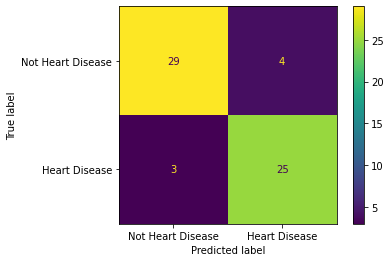

In [185]:
plot_confusion_matrix(pipeline, X_test, y_test, values_format='d', display_labels=["Not Heart Disease","Heart Disease"]);